In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cd gdrive/MyDrive/Colab\ Notebooks/4650Project/

/content/gdrive/MyDrive/Colab Notebooks/4650Project


Loading Data

In [ ]:
sae = open("data/sae_samples.tsv").read().replace('\t', ' ')
sae = sae.split('\n')
sae = sae[0:-1]
print(len(sae))

2019


In [ ]:
sae[-2]

'I am looking for an establishment that has a "mature" clintele, ages 45-50 and older. R&B, OLDIES, JAZZ, SOUTHERN SOUL/BLUES; NO HIP-HOP! CALL (410) 645-0495'

In [ ]:
aave = open("data/aave_samples.tsv").read().replace('\t', ' ')
aave = aave.split('\n')
print(len(aave))

2019


In [ ]:
aave[-2]

'Must be an establishment with a "Grown Folks" clientele; 45-50 and older. R&B, OLDIES, JAZZ, SOUTHERN SOUL/BLUES. NO HIP-HOP! 410-645-0495.'

Re-arrangement & Train-Test-Val Split

In [ ]:
data = {}
data['sae'] = sae
data['aave'] = aave

In [ ]:
import pandas as pd

In [ ]:
data = pd.DataFrame(data)
data

,sae,aave
0,Manti Te'o was having a relationship via telep...,Sooo Manti Te'o was having a online/phone rela...
1,The little girl is not going to win because i ...,this lil girl aint going to win im the king of...
2,He is upstairs rights now and I'm down here ge...,He up stairs rights now and I'm down here gett...
3,"Shit, I am who I am. I'm done apologizing. I'm...",Shit I Am Who Am..Fresh up out of Apologize..I...
4,"It is very rare that I get what I want, but no...",It's very rare that I get what I want. Now tha...
...,...,...
2014,At least I'm happy with knowing I'm always coo...,At least I'm happy with knowing I'm always coo...
2015,"I love when you ad-lib, if that's what you cal...",I love when you ad lip. If that's what you cal...
2016,In search of a nice place to do karaoke or dis...,ISO a nice place to do karaoke or DJ music tha...
2017,"I am looking for an establishment that has a ""...","Must be an establishment with a ""Grown Folks"" ..."


In [ ]:
data[0:1615].to_csv("data/training/train.csv", index=False)
data[1615:1817].to_csv("data/training/val.csv", index=False)
data[1817:].to_csv("data/training/test.csv", index=False)

#Training start here: 

In [ ]:
!pip install transformers

     |████████████████████████████████| 2.9 MB 4.1 MB/s 
     |████████████████████████████████| 3.3 MB 42.9 MB/s 
     |████████████████████████████████| 895 kB 62.3 MB/s 
     |████████████████████████████████| 596 kB 53.4 MB/s 
     |████████████████████████████████| 56 kB 4.8 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import torch
import transformers
import pandas as pd
from pprint import pprint
from tqdm.notebook import tqdm

In [ ]:
train = pd.read_csv("data/training/train.csv")
train

,sae,aave
0,Manti Te'o was having a relationship via telep...,Sooo Manti Te'o was having a online/phone rela...
1,The little girl is not going to win because i ...,this lil girl aint going to win im the king of...
2,He is upstairs rights now and I'm down here ge...,He up stairs rights now and I'm down here gett...
3,"Shit, I am who I am. I'm done apologizing. I'm...",Shit I Am Who Am..Fresh up out of Apologize..I...
4,"It is very rare that I get what I want, but no...",It's very rare that I get what I want. Now tha...
...,...,...
1610,The Spurs are hardly playing like they did the...,The SPURS aren't hardly playing like they did ...
1611,Jamie Foxx was wearing the shoes he wanted. H...,Really Jamie Foxx?! get your hands off my Jord...
1612,This is probably the easiest night to find a m...,This is prolly the easiest night to get some a...
1613,When your ex likes your pictures on instagram....,When Your Ex likes Your Pics On Instagram >>>>...


In [ ]:
val = pd.read_csv("data/training/val.csv")
val

,sae,aave
0,"Damn, I'm tired. I'm glad I only have to work ...",Damn I'm tired glad I only gotta couple weeks ...
1,I got a paid off day I'm going to use for work...,I got a pa day I'm use for work tires as hell ...
2,It is crazy because black men lie to their hoe...,Its crazy cause niggas lie to they HOES sayin ...
3,The higher you go in life the less noise you w...,The Higher You Go In Life The Less Noise You W...
4,Thought of the day: I don't make many promises...,My Thought Of The Day: I Don't Make Many Promi...
...,...,...
197,"So why is my girl missing in action? No text, ...",Sooo Why is My First Laydee M.I.A - No txt No ...
198,The people that I hung out in high school and ...,… The Mfers I Fucked w/ In My Grammar && Middl...
199,"No, Flo didn't hold her hands, bow her head, a...","No Flo DIDN'T hold hands, bow her head in pray..."
200,It's weird as hell I wasn't hungry yesterday. ...,Weird as hell as to why I wasnt hungry yesterd...


In [ ]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels, length):
        self.encodings = encodings
        self.labels = labels
        self.length = length

    def __getitem__(self, idx):
        encoding_item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        label_item = {key: torch.tensor(val[idx]) for key, val in self.labels.items()}
        return encoding_item, label_item

    def __len__(self):
        return self.length

def get_dataset(train, val):
    '''
    train: list of [sae, aave] for training 
    val: list of [sae, aave] for validation
    '''
    from transformers import BartTokenizerFast
    #from transformers import T5Tokenizer

    tokenizer = BartTokenizerFast.from_pretrained('facebook/bart-base')
    #tokenizer = T5Tokenizer.from_pretrained('t5-base')

    train_sae = tokenizer(list(train['sae']), padding=True)
    train_aave = tokenizer(list(train['aave']), padding=True)
    val_sae = tokenizer(list(val['sae']), padding=True)
    val_aave = tokenizer(list(val['aave']), padding=True)

    train_dataset = Dataset(train_sae, train_aave, length = len(list(train['sae'])))
    val_dataset = Dataset(val_sae, val_aave, length=len(list(val['sae'])))

    return train_dataset, val_dataset

In [ ]:
train_dataset, val_dataset = get_dataset(train, val)

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.65k [00:00<?, ?B/s]

In [ ]:
print(len(train_dataset))
print(type(train_dataset))

1615
<class '__main__.Dataset'>


In [ ]:
import torch
from torch.nn import BCEWithLogitsLoss, BCELoss

from torch.utils.data import DataLoader

from transformers import BartForConditionalGeneration, AdamW
#from transformers import T5Tokenizer, T5ForConditionalGeneration, AdamW

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.cuda.is_available())
print(device)

model =  BartForConditionalGeneration.from_pretrained('facebook/bart-base')
#model = T5ForConditionalGeneration.from_pretrained('t5-base')
model.to(device)
model.train()

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=False)

optim = AdamW(model.parameters(), lr=5e-5)

True
cuda


Downloading:   0%|          | 0.00/532M [00:00<?, ?B/s]

In [ ]:
WEIGHT_PATH = 'weights/bart'

In [ ]:
def train(epochs=10):
    train_loss_set = list()
    for epoch in tqdm(range(epochs)):
        for batch in train_loader:
            input, label = batch
            #print(input)

            optim.zero_grad()

            input_ids = input['input_ids'].to(device)
            attention_mask = input['attention_mask'].to(device)

            labels = label['input_ids'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs[0]
            train_loss_set.append(loss.item())

            # Backward pass
            loss.backward()

            optim.step()

        print("Finished epoch {}".format(epoch))

    model.save_pretrained(WEIGHT_PATH)
    return train_loss_set

  0%|          | 0/10 [00:00<?, ?it/s]

Finished epoch 0
Finished epoch 1
Finished epoch 2
Finished epoch 3
Finished epoch 4
Finished epoch 5
Finished epoch 6
Finished epoch 7
Finished epoch 8
Finished epoch 9


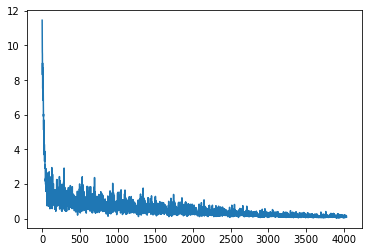

In [ ]:
loss_values = train(10)

import matplotlib.pyplot as plt

plt.plot(loss_values)
plt.show()

In [ ]:
WEIGHT_PATH = 'weights/bart'

In [ ]:
DATAPATH = 'data/training/test.csv'
import torch

from transformers import BartTokenizerFast
tokenizer = BartTokenizerFast.from_pretrained('facebook/bart-base')
"""
from transformers import T5Tokenizer
tokenizer = T5Tokenizer.from_pretrained('t5-base')
"""
def get_data(path=DATAPATH):

  test = pd.read_csv("data/training/test.csv")
  # print(test)
  sae_list = list(test['sae'])
  aave_list = list(test['aave'])
  return sae_list, aave_list

class TestDataset(torch.utils.data.Dataset):
  def __init__(self, encodings, inputs, labels, length):
      self.encodings = encodings
      self.inputs = inputs
      self.labels = labels
      self.length = length

  def __getitem__(self, idx):
      encoding_item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
      return (encoding_item, self.inputs[idx], self.labels[idx])

  def __len__(self):
      return self.length

def get_dataset(sae_list, aave_list):

  sae_encodings = tokenizer(sae_list, padding=True)

  test_dataset = TestDataset(encodings = sae_encodings, inputs = sae_list, labels = aave_list, length = len(aave_list))

  return test_dataset

In [ ]:
sae_list, aave_list = get_data(path = 'data/training/test.csv')
test_dataset = get_dataset(sae_list, aave_list)
# print(test_dataset.inputs)
# print(test_dataset.labels)

In [ ]:
#from transformers import T5ForConditionalGeneration
from transformers import BartForConditionalGeneration

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm

def validate(val_dataset):
    #model =  T5ForConditionalGeneration.from_pretrained(WEIGHT_PATH)
    model =  BartForConditionalGeneration.from_pretrained(WEIGHT_PATH)
    model.to(device)
    model.eval()

    val_loader = DataLoader(val_dataset, batch_size=5, shuffle=False)

    print("Evaluating on {} questions".format(len(val_dataset)))
    
    org_inputs = []
    generated_texts = []
    references = []
    for batch in val_loader:
            input, org_input, reference = batch
            for o in org_input:
              org_inputs.append(o)
            for r in reference:
              references.append(r)

            input_ids = input['input_ids'].to(device)
            attention_mask = input['attention_mask'].to(device)

            with torch.no_grad():
                generated_sequences = model.generate(
                    input_ids=input_ids,
                    attention_mask = attention_mask,
                    max_length=,
                    temperature=0.6008,
                    top_k=5,
                    top_p=0.9,
                    repetition_penalty=0.8,
                    )
                for sequence in generated_sequences:
                    hypothesis = tokenizer.decode(sequence, clean_up_tokenization_spaces=True)
                    hypothesis = hypothesis[7:]
                    #print(hypothesis)
                    end = hypothesis.index('</s>')
                    hypothesis = hypothesis[0:end]
                    generated_texts.append(hypothesis)
    return org_inputs, generated_texts, references

In [ ]:
org_inputs, generated_texts, references = validate(test_dataset)

Evaluating on 202 questions


In [ ]:
print(len(org_inputs))
print(len(generated_texts))
print(len(references))

202
202
202


In [ ]:
for i in range(0,10):
  print(org_inputs[i])
  print(references[i])
  print(generated_texts[i])
  print('==========================================================================')

"Silver lining"? Really, jackass? People could have lost their lives and you're worrying about The Heat winning? How insensitive
"Silver Lining" really Jackass? People could have lost their lives & ur worrying about The Heat winning.How insensitive
"Silver lining"? Really jackass? People could have lost their lives and you worrying about the heat winning? How insensitive
I feel you! I only ball when there is a tournament. Still have game, though. Laugh out loud. If you ever are in  Chicago City, I will play you. Laugh out loud.
I feel ya! I only ball when there is a tournament...still got game thou...lol. If u ever in Chi city ill play u...lol
I feel you! I only ball when there is a tournament still have game tho lol. If you ever are in ChiCity I will play you lol
For those who are interested, I will be playing the old school and house music again on Wednesdays as of September 4th, 2013... I have momentarily stopped playing them because of the annual jazz event
****ATTENTION EVERYONE I

In [ ]:
output = {}
output['org_inputs'] = org_inputs
output['references'] = references
output['generated_texts'] = generated_texts
output = pd.DataFrame(output)
output.to_csv("data/bart_output.csv", index=False)